In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
df = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/data_retail.csv', sep=';')

In [3]:
print('Lima data teratas:')
df.head()

Lima data teratas:


,no,Row_Num,Customer_ID,Product,First_Transaction,Last_Transaction,Average_Transaction_Amount,Count_Transaction
0,1,1,29531,Jaket,1466304274396,1538718482608,1467681,22
1,2,2,29531,Sepatu,1406077331494,1545735761270,1269337,41
2,3,3,141526,Tas,1493349147000,1548322802000,310915,30
3,4,4,141526,Jaket,1493362372547,1547643603911,722632,27
4,5,5,37545,Sepatu,1429178498531,1542891221530,1775036,25


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   no                          100000 non-null  int64 
 1   Row_Num                     100000 non-null  int64 
 2   Customer_ID                 100000 non-null  int64 
 3   Product                     100000 non-null  object
 4   First_Transaction           100000 non-null  int64 
 5   Last_Transaction            100000 non-null  int64 
 6   Average_Transaction_Amount  100000 non-null  int64 
 7   Count_Transaction           100000 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 6.1+ MB


Mengubah kolom first transaction dan last transaction menjadi datetime

In [5]:
df['First_Transaction'] = pd.to_datetime(df['First_Transaction']/1000, unit='s', origin='1970-01-01')
df['Last_Transaction'] = pd.to_datetime(df['Last_Transaction']/1000, unit='s', origin='1970-01-01')

In [6]:
df.head()

,no,Row_Num,Customer_ID,Product,First_Transaction,Last_Transaction,Average_Transaction_Amount,Count_Transaction
0,1,1,29531,Jaket,2016-06-19 02:44:34.395999908,2018-10-05 05:48:02.608000040,1467681,22
1,2,2,29531,Sepatu,2014-07-23 01:02:11.493999958,2018-12-25 11:02:41.269999981,1269337,41
2,3,3,141526,Tas,2017-04-28 03:12:27.000000000,2019-01-24 09:40:02.000000000,310915,30
3,4,4,141526,Jaket,2017-04-28 06:52:52.546999931,2019-01-16 13:00:03.911000013,722632,27
4,5,5,37545,Sepatu,2015-04-16 10:01:38.530999899,2018-11-22 12:53:41.529999970,1775036,25


Churn customers adalah pelanggan yang tidak melakukan transaksi selama 6 bulan dari data transaksi terakhir

In [7]:
print('transaksi terakhir dilakukan pada:', max(df['Last_Transaction']))

transaksi terakhir dilakukan pada: 2019-02-01 23:57:57.286000013


In [8]:
#pelanggan yang melakukan transaksi sebelum bulan 8 tahun 2018 dianggap sebagai churn customer
df.loc[df['Last_Transaction'] <= '2018-08-01', 'is_churn'] = 'Yes'
df.loc[df['Last_Transaction'] > '2018-08-01', 'is_churn'] = 'No'

In [9]:
#menghapus kolom yang tidak diperlukan
df = df.drop(['no', 'Row_Num'], axis=1)

In [10]:
df['Year_First_Transaction'] = df['First_Transaction'].dt.year
df['Year_Last_Transaction'] = df['Last_Transaction'].dt.year

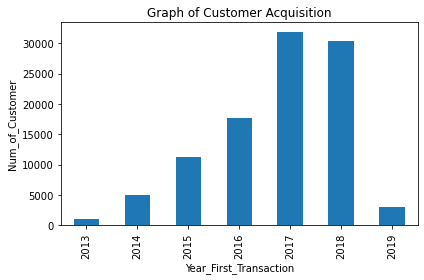

In [11]:
df.groupby(['Year_First_Transaction'])['Customer_ID'].count().plot(x='Year_First_Transaction',
                                                                   y='Customer_ID', 
                                                                   kind='bar', 
                                                                   title='Graph of Customer Acquisition')
plt.xlabel('Year_First_Transaction')
plt.ylabel('Num_of_Customer')
plt.tight_layout()
plt.show()

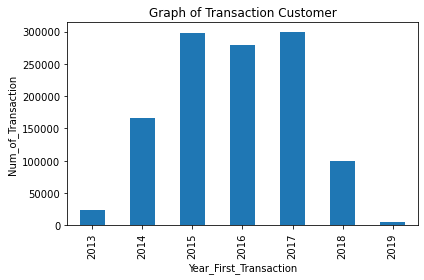

In [12]:
plt.clf()
df_year = df.groupby(['Year_First_Transaction'])['Count_Transaction'].sum()
df_year.plot(x='Year_First_Transaction', y='Count_Transaction', kind='bar', title='Graph of Transaction Customer')
plt.xlabel('Year_First_Transaction')
plt.ylabel('Num_of_Transaction')
plt.tight_layout()
plt.show()

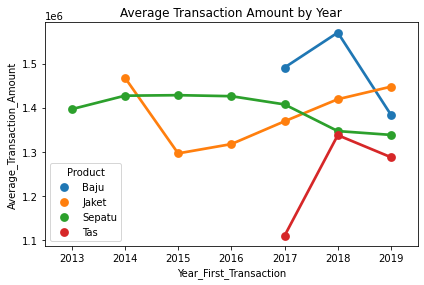

In [13]:
plt.clf()
sns.pointplot(data = df.groupby(['Product', 'Year_First_Transaction']).mean().reset_index(),
x='Year_First_Transaction',
y='Average_Transaction_Amount',
hue='Product')
plt.tight_layout()
plt.title('Average Transaction Amount by Year')
plt.show()

In [14]:
df_piv = df.pivot_table(index='is_churn', columns='Product', values='Customer_ID', aggfunc='count', fill_value=0)
df_piv.head()

Product,Baju,Jaket,Sepatu,Tas
is_churn,,,,
No,1268,11123,16064,4976
Yes,2144,23827,33090,7508


In [15]:
plot_product = df_piv.count().sort_values(ascending=False).head(5).index
plot_product

Index(['Tas', 'Sepatu', 'Jaket', 'Baju'], dtype='object', name='Product')

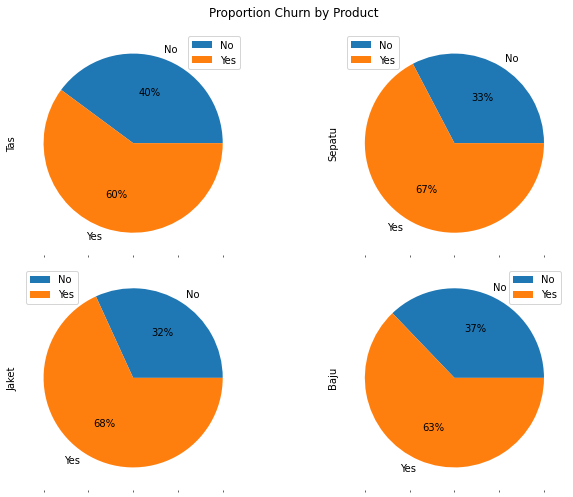

In [30]:
df_piv = df_piv.reindex(columns=plot_product)
df_piv.plot.pie(subplots=True, figsize=(10, 7), layout=(-1, 2), autopct='%1.0f%%', title='Proportion Churn by Product')
plt.tight_layout()
plt.show()

In [17]:
#Kategorisasi jumlah transaksi
def func(row):
    if row['Count_Transaction'] == 1:
        val = '1. 1'
    elif (row['Count_Transaction'] >1 and row['Count_Transaction'] <= 3):
        val ='2. 2 - 3'
    elif (row['Count_Transaction'] >3 and row['Count_Transaction'] <= 6):
        val ='3. 4 - 6'
    elif (row['Count_Transaction'] >6 and row['Count_Transaction'] <= 10):
        val ='4. 7 - 10'
    else:
        val ='5. >10'
    return val

In [18]:
df['Count_Transaction_Category'] = df.apply(func, axis=1)

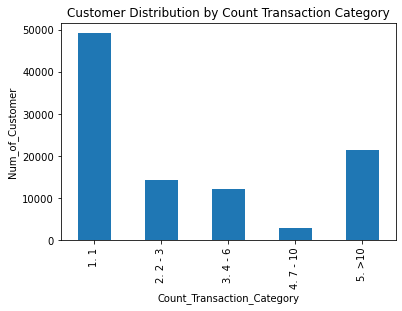

In [19]:
df_year = df.groupby(['Count_Transaction_Category'])['Customer_ID'].count()
df_year.plot(x='Count_Transaction_Category', y='Customer_ID', kind='bar', title='Customer Distribution by Count Transaction Category')
plt.xlabel('Count_Transaction_Category')
plt.ylabel('Num_of_Customer')
plt.show()

In [20]:
# Kategorisasi rata-rata besar transaksi
def f(row):
    if (row['Average_Transaction_Amount'] >= 100000 and row['Average_Transaction_Amount'] <=200000):
        val ='1. 100.000 - 250.000'
    elif (row['Average_Transaction_Amount'] >250000 and row['Average_Transaction_Amount'] <= 500000):
        val ='2. >250.000 - 500.000'
    elif (row['Average_Transaction_Amount'] >500000 and row['Average_Transaction_Amount'] <= 750000):
        val ='3. >500.000 - 750.000'
    elif (row['Average_Transaction_Amount'] >750000 and row['Average_Transaction_Amount'] <= 1000000):
        val ='4. >750.000 - 1.000.000'
    elif (row['Average_Transaction_Amount'] >1000000 and row['Average_Transaction_Amount'] <= 2500000):
        val ='5. >1.000.000 - 2.500.000'
    elif (row['Average_Transaction_Amount'] >2500000 and row['Average_Transaction_Amount'] <= 5000000):
        val ='6. >2.500.000 - 5.000.000'
    elif (row['Average_Transaction_Amount'] >5000000 and row['Average_Transaction_Amount'] <= 10000000):
        val ='7. >5.000.000 - 10.000.000'
    else:
        val ='8. >10.000.000'
    return val

In [21]:
df['Average_Transaction_Amount_Category'] = df.apply(f, axis=1)

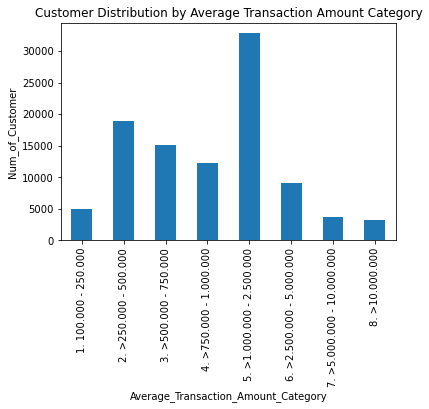

In [22]:
df_year = df.groupby(['Average_Transaction_Amount_Category'])['Customer_ID'].count()
df_year.plot(x='Average_Transaction_Amount_Category', y='Customer_ID',kind='bar', title='Customer Distribution by Average Transaction Amount Category')
plt.xlabel('Average_Transaction_Amount_Category')
plt.ylabel('Num_of_Customer')
plt.show()

In [33]:
# Feature column: Year_Diff
df['Year_Diff']=df['Year_Last_Transaction']-df['Year_First_Transaction']

# Nama-nama feature columns
feature_columns = ['Average_Transaction_Amount', 'Count_Transaction', 'Year_Diff']

# Features variable
X = df[feature_columns]

# Target variable
y = df['is_churn']


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [35]:
# Inisiasi model logreg
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train, y_train)

# Predict model
y_pred=logreg.predict(X_test)

# Evaluasi model menggunakan confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[    1  8330]
 [    3 16666]]


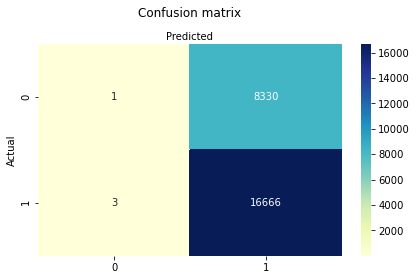

In [36]:
class_names = [0, 1]
fig, ax = plt.subplots()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='YlGnBu', fmt='g')
ax.xaxis.set_label_position('top')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [37]:
print('Accuracy :', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='micro'))
print('Recall :', recall_score(y_test, y_pred, average='micro'))

Accuracy : 0.66668
Precision: 0.66668
Recall : 0.66668
